## Name : Snehal Shyam Jagtap

### Assignment No : 20


## FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
               
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-02-01,0.7818
2,1990-03-01,0.7867
3,1990-04-01,0.7860
4,1990-05-01,0.7849


#### Plot the time series

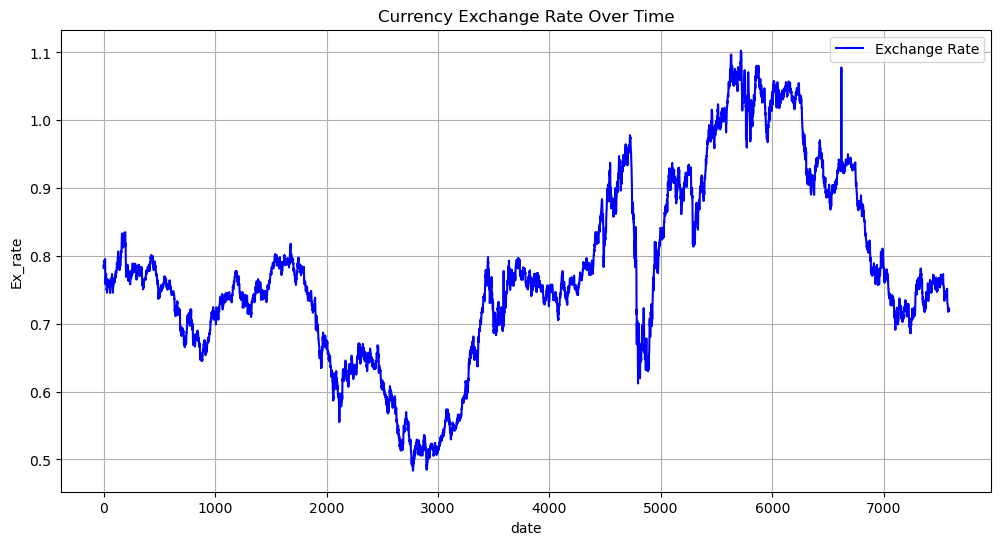

In [3]:
plt.figure(figsize = (12, 6))
plt.plot(df['Ex_rate'], label = 'Exchange Rate', color = 'blue')
plt.title('Currency Exchange Rate Over Time')
plt.xlabel('date')
plt.ylabel("Ex_rate")
plt.legend()
plt.grid(True)
plt.show()

#### Analyze trends and seasonality

- Trend: The long-term movement of the currency exchange rate.
- Seasonality: Repeating short-term patterns (e.g., seasonal fluctuations over months).
- Residual: The noise or irregular components after removing the trend and seasonality.

In [4]:
import statsmodels.api as sm

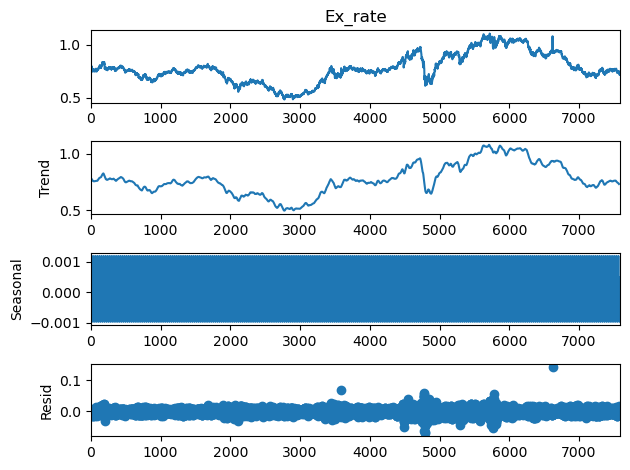

In [5]:
decomposition = sm.tsa.seasonal_decompose(df['Ex_rate'], model = 'additive', period = 30)

decomposition.plot()
plt.show()

#### Check  for Anomalies

Anomalies (outliers) can be visualized by looking at the residual component from the decomposition.

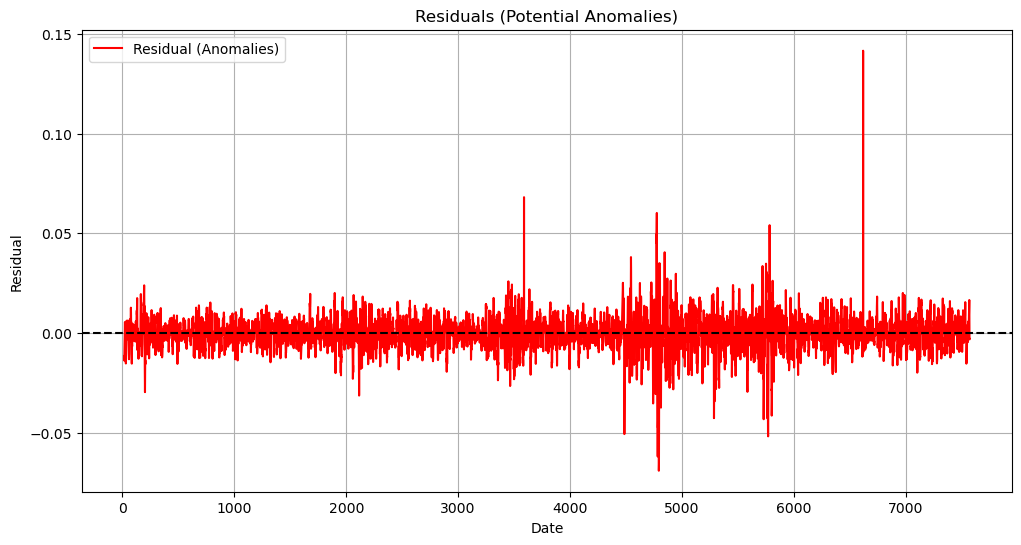

In [6]:
residual  = decomposition.resid

plt.figure(figsize = (12,6))
plt.plot(residual, label = 'Residual (Anomalies)', color = 'red')
plt.title("Residuals (Potential Anomalies)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# We can  further detect anomalies with thresholds

threshold = 2 * residual.std()
anomalies = residual[abs(residual) > threshold]
print("Anomalies Detected on the Following Dates:")
print(anomalies)

Anomalies Detected on the Following Dates:
131     0.017488
163     0.017088
164     0.019513
191     0.017355
192     0.020037
          ...   
7104   -0.019917
7105   -0.019451
7106   -0.017346
7118    0.017605
7332    0.017298
Name: resid, Length: 320, dtype: float64


#### Data Preprocessing

In [8]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

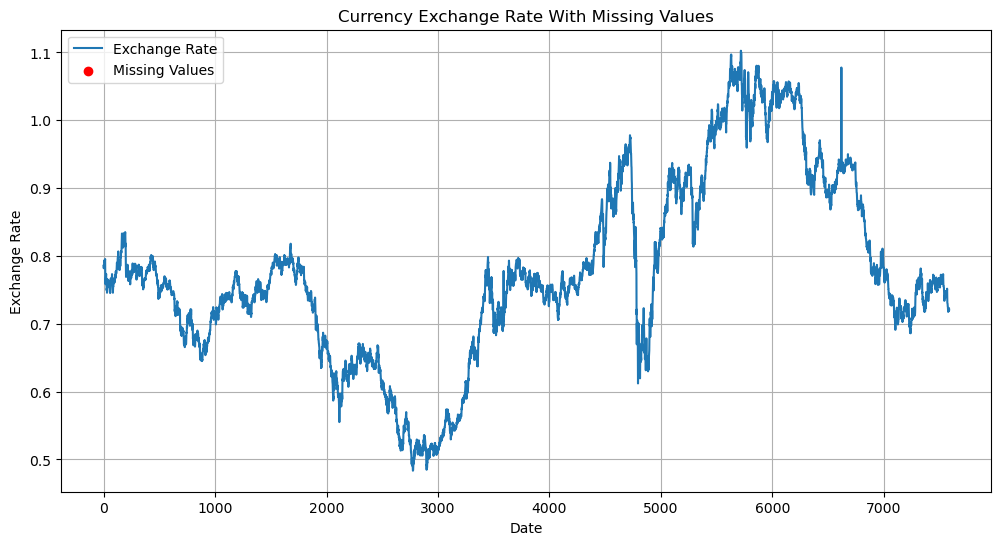

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(df['Ex_rate'], label = 'Exchange Rate')
plt.scatter(df.index[df['Ex_rate'].isnull()], [df['Ex_rate'].mean()] * df['Ex_rate'].isnull().sum(), color = 'red', label = 'Missing Values', zorder = 2)
plt.title('Currency Exchange Rate With Missing Values')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df = df.dropna()

In [22]:
df.isnull().sum()

date       0
Ex_rate    0
Z_Score    0
dtype: int64

## Handling Anomalies

In [24]:
from scipy import stats

In [25]:
df['Z_Score'] = stats.zscore(df['Ex_rate'])

In [26]:
anomalies = df[df['Z_Score'].abs() > 3]
print("Anomalies Detected: \n", anomalies)

Anomalies Detected: 
 Empty DataFrame
Columns: [date, Ex_rate, Z_Score]
Index: []


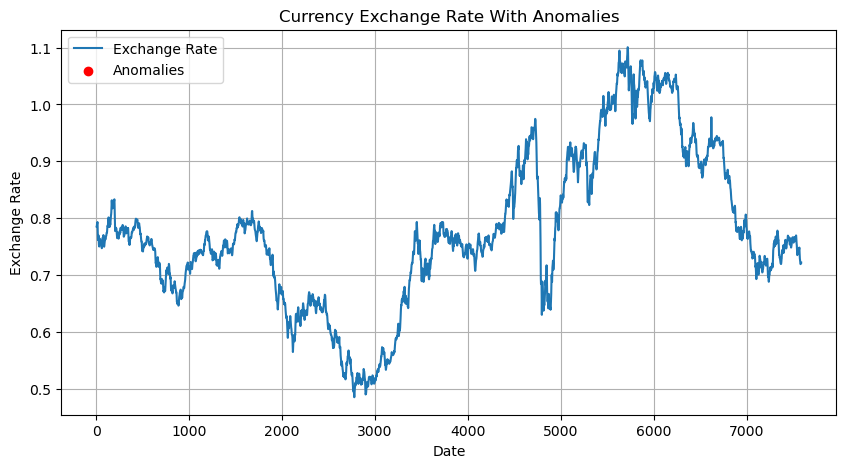

In [27]:
plt.figure(figsize = (10, 5))
plt.plot(df['Ex_rate'], label = 'Exchange Rate')
plt.scatter(anomalies.index, anomalies['Ex_rate'], color = 'red', label = 'Anomalies', zorder = 2)
plt.title("Currency Exchange Rate With Anomalies")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

### Handling Anomalies

In [28]:
# Remove rows with  anomalies (based on z-score)
df = df[df['Z_Score'].abs() <= 3]

In [29]:
# Replace anomalies with rolling average

df['Ex_rate'] = df['Ex_rate'].rolling(window = 3, center =  True).mean()

# alternatively interpolate the values to smooth anomalies
df['Ex_rate'] = df['Ex_rate'].interpolate()

## Final Data Check

After handling the missing values and anomalies, you can check the dataset again to ensure it's clean and ready for further analysis or modeling.

In [30]:
print(df.isnull().sum())
print("Final Dataset:\n", df.head())

date       0
Ex_rate    1
Z_Score    0
dtype: int64
Final Dataset:
         date   Ex_rate   Z_Score
2 1990-03-01       NaN  0.059687
3 1990-04-01  0.785589  0.062535
4 1990-05-01  0.786244  0.067092
5 1990-06-01  0.787363  0.074090
6 1990-07-01  0.788800  0.087109


In [31]:
df = df.dropna()

In [33]:
print(df.isnull().sum())
print(df.head())

date       0
Ex_rate    0
Z_Score    0
dtype: int64
        date   Ex_rate   Z_Score
3 1990-04-01  0.785589  0.062535
4 1990-05-01  0.786244  0.067092
5 1990-06-01  0.787363  0.074090
6 1990-07-01  0.788800  0.087109
7 1990-08-01  0.790244  0.098663


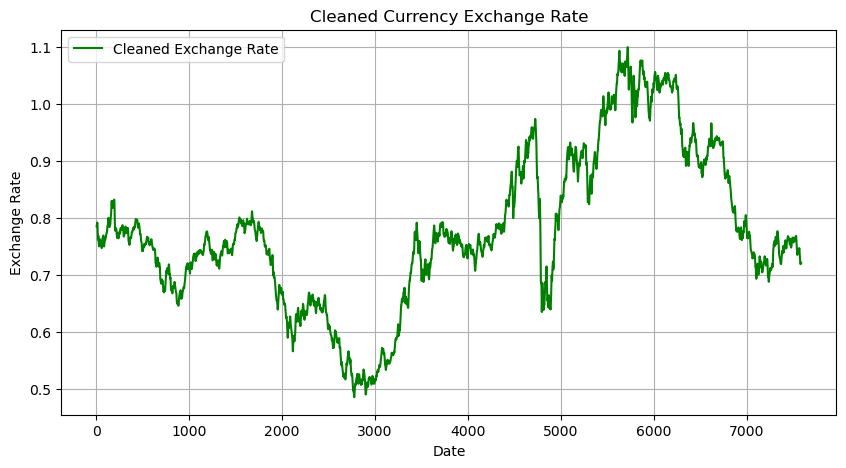

In [34]:
plt.figure(figsize = (10, 5))
plt.plot(df['Ex_rate'], label = 'Cleaned Exchange Rate', color = 'green')
plt.title("Cleaned Currency Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

## Model  Building - ARIMA

In [36]:
# Check for stationarity  using ADF (Augmented Dickey-Fuller) Test

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print('p-value', result[1])



ADF Statistic: -1.8699556289320602
p-value 0.3463242031942699


In [37]:
# If the p-value > 0.05, apply differencing to make the series stationary 


df_diff = df['Ex_rate'].diff().dropna()


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


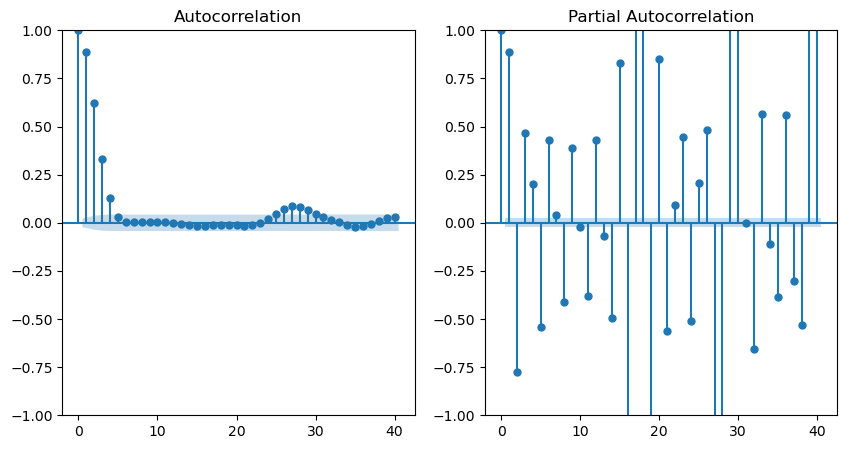

In [38]:
# plot ACF and PACF to estimate p and q

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
sm.graphics.tsa.plot_acf(df_diff, lags = 40, ax = ax1)
sm.graphics.tsa.plot_pacf(df_diff, lags = 40, ax = ax2)
plt.show()

### Model Fitting : Fit the  ARIMA Model

In [40]:
 from statsmodels.tsa.arima.model import ARIMA

In [43]:
p, d, q = 1,1,1
model = ARIMA(df['Ex_rate'], order = (p, d, q))
model_fit = model.fit()

print(model_fit.summary())

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7585
Model:                 ARIMA(1, 1, 1)   Log Likelihood               40856.527
Date:                Sun, 20 Oct 2024   AIC                         -81707.055
Time:                        15:40:37   BIC                         -81686.253
Sample:                             0   HQIC                        -81699.916
                               - 7585                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7889      0.004    213.993      0.000       0.782       0.796
ma.L1       2.471e-06      0.009      0.000      1.000      -0.017       0.017
sigma2      1.224e-06   1.51e-08     81.274      0.0

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Diagnostics : Analyze Residuals

After fitting the ARIMA model  , you should check the residuals to ensure the model is adequate. The residuals should resemble white noise (i.e. have no autocorrelation and  no clear pattern).

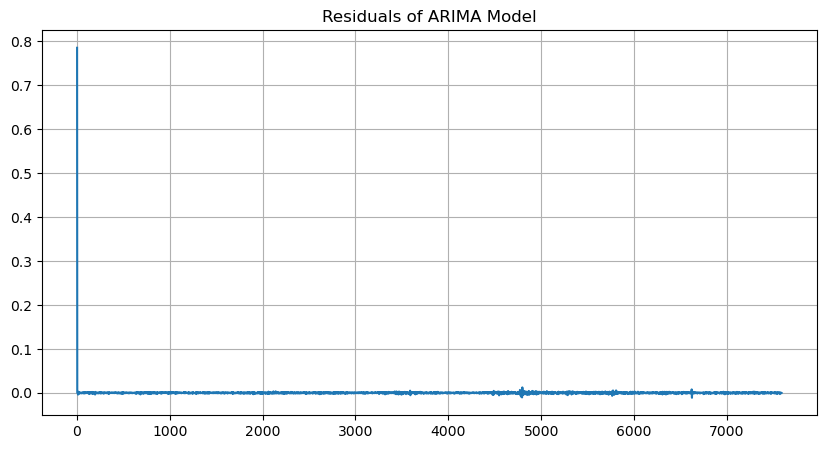

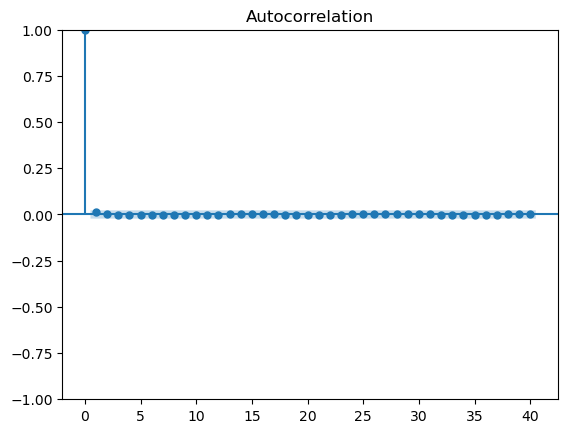

In [46]:
# Plot the residuals 

residuals = model_fit.resid

plt.figure(figsize = (10,5))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.grid(True)
plt.show()

# ACF plot of residuals

sm.graphics.tsa.plot_acf(residuals, lags = 40)
plt.show()

In [47]:
# perform the Ljung-Box test to check for autocorrelation in the residuals

from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_test  = acorr_ljungbox(residuals, lags = [10], return_df = True)
print(ljung_box_test)

     lb_stat  lb_pvalue
10  1.691588   0.998204


### Forecasting : Perform Out-of-Sample Forecasting

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


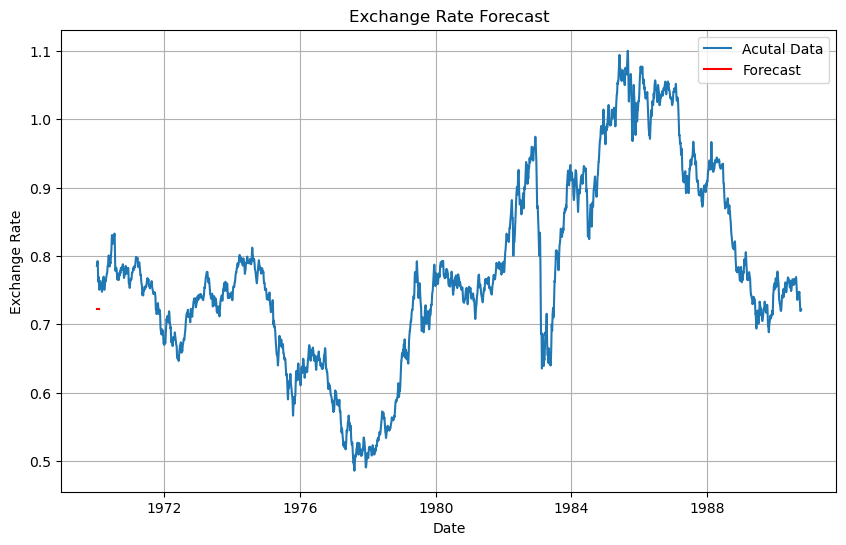

In [49]:
# forecast future exchange rates

forecast_steps = 30
forecast = model_fit.forecast(steps = forecast_steps)

# plot forecasted values

plt.figure(figsize = (10,6))
plt.plot(df.index, df['Ex_rate'], label = 'Acutal Data')
plt.plot(pd.date_range(df.index[-1], periods = forecast_steps, freq = 'D'), forecast, label = 'Forecast', color = 'red')
plt.title("Exchange Rate Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

## Model Building - Exponential Smoothing

### Model Selection

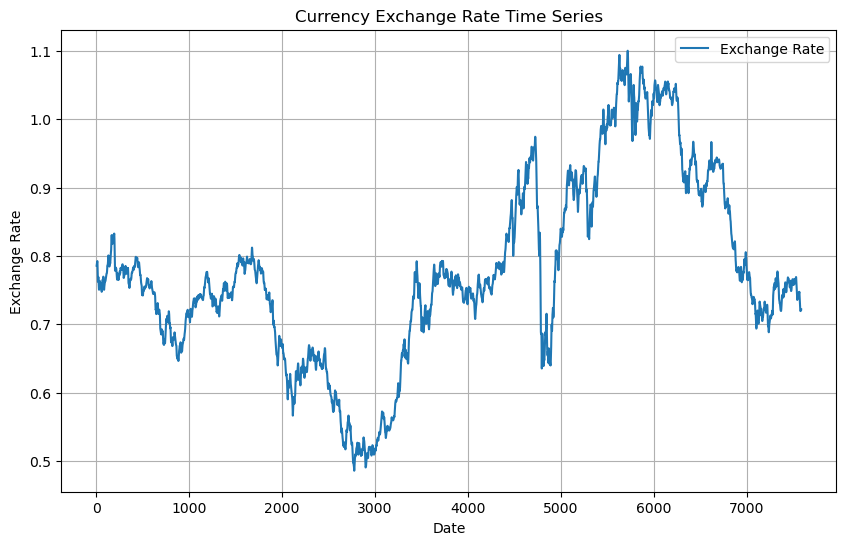

In [51]:
plt.figure(figsize = (10,6))
plt.plot(df['Ex_rate'], label = "Exchange Rate")
plt.title("Currency Exchange Rate Time Series")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

### Parameter Optimization

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [55]:
model = ExponentialSmoothing(df['Ex_rate'], trend = 'add', seasonal = 'add', seasonal_periods = 12)
fit_model = model.fit(optimized = True)

print(fit_model.summary())

# forecast future values

forecast_steps = 30
forecast = fit_model.forecast(steps = forecast_steps)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7585
Model:             ExponentialSmoothing   SSE                              0.009
Optimized:                         True   AIC                        -103115.934
Trend:                         Additive   BIC                        -103004.992
Seasonal:                      Additive   AICC                       -103115.844
Seasonal Periods:                    12   Date:                 Sun, 20 Oct 2024
Box-Cox:                          False   Time:                         15:59:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


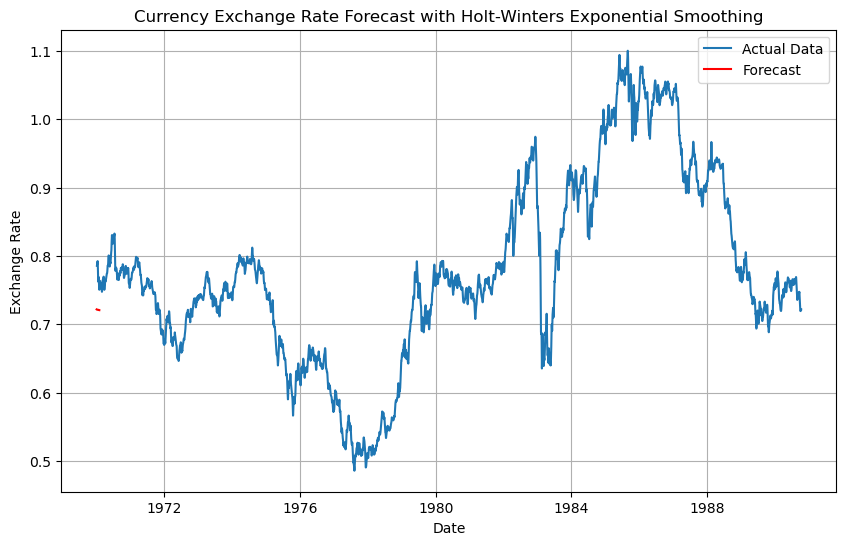

In [56]:
# plot the actual data and forecast

plt.figure(figsize = (10,6))
plt.plot(df.index, df['Ex_rate'], label = 'Actual Data')
plt.plot(pd.date_range(df.index[-1], periods = forecast_steps, freq = 'D'), forecast, label = 'Forecast', color = 'red')
plt.title("Currency Exchange Rate Forecast with Holt-Winters Exponential Smoothing")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

### AIC/BIC for Model Selection : 


In [57]:
aic_value = fit_model.aic
print(f"AIC of the model : {aic_value}")

AIC of the model : -103115.93449578845


### Model Fitting and Forecasting

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


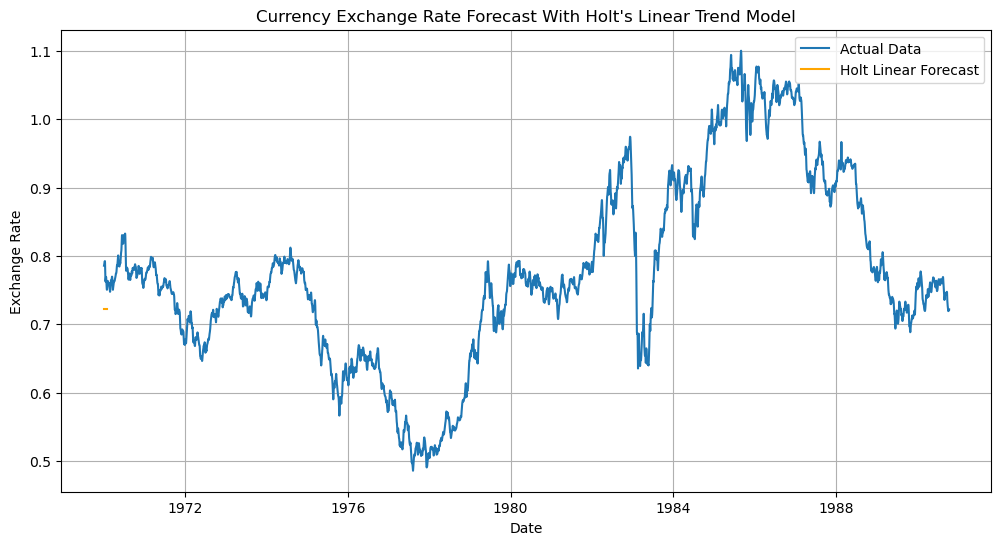

In [59]:
holt_model = ExponentialSmoothing(df['Ex_rate'], trend = 'add', seasonal = None)
holt_fit = holt_model.fit()

holt_forecast = holt_fit.forecast(steps = 30)

plt.figure(figsize = (12,6))
plt.plot(df.index, df['Ex_rate'], label = 'Actual Data')
plt.plot(pd.date_range(df.index[-1], periods = 30, freq = 'D'), holt_forecast, label = 'Holt Linear Forecast', color = 'orange')
plt.title("Currency Exchange Rate Forecast With Holt's Linear Trend Model")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


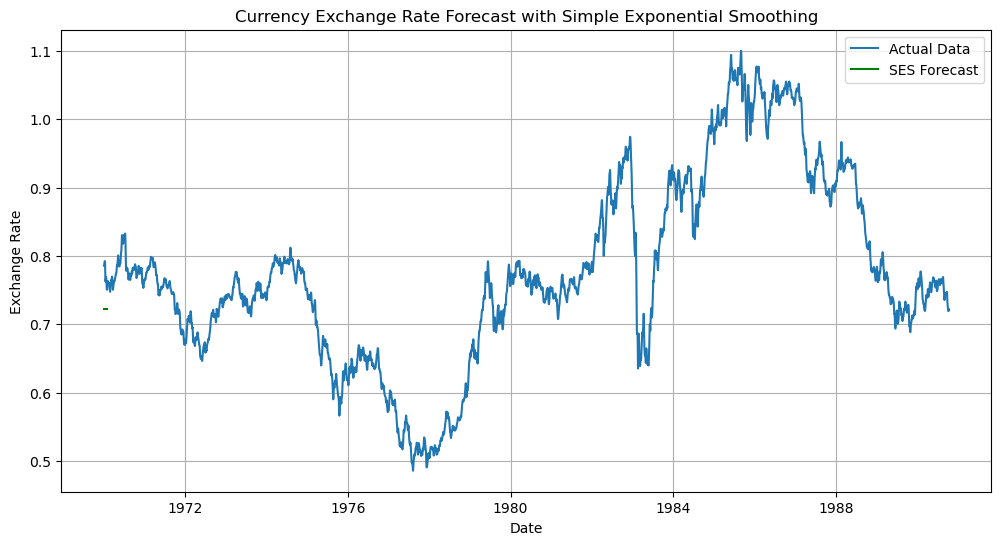

In [61]:
ses_model = ExponentialSmoothing(df['Ex_rate'], trend = None,seasonal = None)
ses_fit = ses_model.fit()

ses_forecast = ses_fit.forecast(steps = 30)

plt.figure(figsize = (12,6))
plt.plot(df.index, df['Ex_rate'], label = 'Actual Data')
plt.plot(pd.date_range(df.index[-1], periods = 30, freq = 'D'), ses_forecast, label = 'SES Forecast', color = 'green')
plt.title("Currency Exchange Rate Forecast with Simple Exponential Smoothing")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

In [62]:
mse_holt_winters = mean_squared_error(df['Ex_rate'], fit_model.fittedvalues)
mse_holt = mean_squared_error(df['Ex_rate'], holt_fit.fittedvalues)
mse_ses = mean_squared_error(df['Ex_rate'], ses_fit.fittedvalues)

print(f"MSE Holt-Winters : {mse_holt_winters}")
print(f"MSE Holt: {mse_holt}")
print(f"MSE Simple Exponential Smoothing : {mse_ses}")

MSE Holt-Winters : 1.2418148610639755e-06
MSE Holt: 1.2428014342421874e-06
MSE Simple Exponential Smoothing : 5.4884169721136405e-06
